In [1]:
import os
import sys
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/notebooks/reports/"))
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import plot.viz_sequence as viz_sequence
from util import figure_to_vdom_image, create_motif_similarity_matrix
import h5py
import numpy as np
import sklearn.cluster
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import vdom.helpers as vdomh
from IPython.display import display
import tqdm
tqdm.tqdm_notebook(range(1))

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|<bar/>| 0/1 [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


In [3]:
tf_name = "E2F6"
num_tasks = 2

motif_file = "/users/amtseng/tfmodisco/results/motifs/tfmodisco/%s_tfmodisco_motifs.h5" % tf_name

best_model_types = list("MM")

multitask_finetune_model_def_tsv = "/users/amtseng/tfmodisco/results/model_stats/multitask_profile_finetune_stats.tsv"
singletask_finetune_model_def_tsv = "/users/amtseng/tfmodisco/results/model_stats/singletask_profile_finetune_stats.tsv"

### Helper functions

In [4]:
sanitize_fold = lambda fold: "F" + fold.split("_")[1]
sanitize_task = lambda task: "T" + task.split("_")[1]

def import_all_tfmodisco_motifs(motif_file):
    """
    From a file containing all motifs for that TF, imports the
    trimmed CWMs of all conditions as a dictionary. Returns a dictionary
    of motifs, mapping a unique key to the trimmed CWM.
    """
    motifs = {}
    with h5py.File(motif_file, "r") as f:
        # Multi-task, all 10 folds
        mt = f["multitask"]
        for fold in mt.keys():
            mt_fold = mt[fold]
            for key in ("count", "profile"):
                mt_fold_key = mt_fold[key]
                for motif_key in mt_fold_key.keys():
                    if motif_key.startswith("0_"):
                        # Positive metacluster only
                        name = "MT:%s:%s:%s" % (sanitize_fold(fold), key[0].upper(), motif_key)
                        motifs[name] = mt_fold_key[motif_key]["cwm_trimmed"][:]
        
        # Single-task, all 10 folds for all tasks
        st = f["singletask"]
        for task in st.keys():
            st_task = st[task]
            for fold in st_task.keys():
                st_task_fold = st_task[fold]
                for key in ("count", "profile"):
                    st_task_fold_key = st_task_fold[key]
                    for motif_key in st_task_fold_key.keys():
                        if motif_key.startswith("0_"):
                            # Positive metacluster only
                            name = "ST:%s:%s:%s:%s" % (sanitize_task(task), sanitize_fold(fold), key[0].upper(), motif_key)
                            motifs[name] = st_task_fold_key[motif_key]["cwm_trimmed"][:]
        
        # Multi-task fine-tune, all tasks plus aggregate task
        mtft = f["multitask_finetune"]
        for task in mtft.keys():
            mtft_task = mtft[task]
            for key in ("count", "profile"):
                mtft_task_key = mtft_task[key]
                for motif_key in mtft_task_key.keys():
                    if motif_key.startswith("0_"):
                        # Positive metacluster only
                        name = "MTFT:%s:%s:%s" % (sanitize_task(task), key[0].upper(), motif_key)
                        motifs[name] = mtft_task_key[motif_key]["cwm_trimmed"][:]
        
        # Single-task fine-tune, all tasks
        stft = f["singletask_finetune"]
        for task in stft.keys():
            stft_task = stft[task]
            for key in ("count", "profile"):
                stft_task_key = stft_task[key]
                for motif_key in stft_task_key.keys():
                    if motif_key.startswith("0_"):
                        # Positive metacluster only
                        name = "STFT:%s:%s:%s" % (sanitize_task(task), key[0].upper(), motif_key)
                        motifs[name] = stft_task_key[motif_key]["cwm_trimmed"][:]
        
    return motifs

In [5]:
def get_num_seqlets(motif_key):
    """
    Fetches the number of seqlets initially mapped to the given motif from the
    original TF-MoDISco file.
    """
    base_path = "/users/amtseng/tfmodisco/results/tfmodisco"
    cond_type = motif_key.split(":")[0]
    if cond_type == "MTFT":
        # Get best fold
        best_mt_fold = None
        with open(multitask_finetune_model_def_tsv, "r") as f:
            for line in f:
                tokens = line.strip().split("\t")
                if tokens[0] == tf_name and int(tokens[1]) == num_tasks - 1:
                    assert best_mt_fold is None
                    best_mt_fold = int(tokens[2])
        task, head, pattern = motif_key.split(":")[1:]
        task = task[1:]
        head = "profile" if head == "P" else "count"
        path = os.path.join(
            base_path,
            "multitask_profile_finetune",
            "%s_multitask_profile_finetune_fold%d" % (tf_name, best_mt_fold)
        )
        if task == "agg":
            path = os.path.join(
                path,
                "%s_multitask_profile_finetune_fold%d_%s_tfm.h5" % (tf_name, best_mt_fold, head)
            )
        else:
            path = os.path.join(
                path,
                "%s_multitask_profile_finetune_task%s_fold%d_%s_tfm.h5" % (tf_name, task, best_mt_fold, head)
            )
    elif cond_type == "STFT":
        # Get best fold
        best_st_folds = []
        with open(singletask_finetune_model_def_tsv, "r") as f:
            for line in f:
                tokens = line.strip().split("\t")
                if tokens[0] == tf_name:
                    best_st_folds.append(int(tokens[2]))
        assert len(best_st_folds) == num_tasks
        task, head, pattern = motif_key.split(":")[1:]
        task = task[1:]
        head = "profile" if head == "P" else "count"
        best_st_fold = best_st_folds[int(task)]
        path = os.path.join(
            base_path,
            "singletask_profile_finetune",
            "%s_singletask_profile_finetune_fold%d" % (tf_name, best_st_fold),
            "task_%s" % task,
            "%s_singletask_profile_finetune_task%s_fold%d_%s_tfm.h5" % (tf_name, task, best_st_fold, head)
        )        
    elif cond_type == "MT":
        fold, head, pattern = motif_key.split(":")[1:]
        fold = fold[1:]
        head = "profile" if head == "P" else "count"
        path = os.path.join(
            base_path,
            "multitask_profile",
            "%s_multitask_profile_fold%s" % (tf_name, fold),
            "%s_multitask_profile_fold%s_%s_tfm.h5" % (tf_name, fold, head)
        )
    elif cond_type == "ST":
        task, fold, head, pattern = motif_key.split(":")[1:]
        task = task[1:]
        fold = fold[1:]
        head = "profile" if head == "P" else "count"
        path = os.path.join(
            base_path,
            "singletask_profile",
            "%s_singletask_profile_fold%s" % (tf_name, fold),
            "task_%s" % task,
            "%s_singletask_profile_task%s_fold%s_%s_tfm.h5" % (tf_name, task, fold, head)
        )
    else:
        raise ValueError("Unknown model condition type")
        
    # Now that we have the path, import the number of seqlets for the given pattern
    metacluster_key, pattern_key = pattern.split("_")
    with h5py.File(path, "r") as f:
        metacluster = f["metacluster_idx_to_submetacluster_results"]["metacluster_%s" % metacluster_key]
        patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
        seqlets = patterns["pattern_%s" % pattern_key]["seqlets_and_alnmts"]["seqlets"]
        return len(seqlets)

In [6]:
def make_cdf(ax, data, steps=1000, density=False, inverse=False, **kwargs):
    """
    Plots a CDF to the given axes. `steps` is the number of steps in the
    CDF. If `inverse` is True, plots an inverse CDF (AKA survivorship plot).
    `density` is whether or not to normalize to fractions.
    """
    hist, bin_edges = np.histogram(data, bins=steps)
    if inverse:
        cumsum = len(data) - np.cumsum(hist)
    else:
        cumsum = np.cumsum(hist)
    if density:
        cumsum = cumsum / len(data)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    ax.step(bin_centers, cumsum, **kwargs)

In [7]:
def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Order cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = np.argsort(-np.min(kmeans_centers, axis=1))

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds, cluster_assignments[cluster_inds]

In [8]:
def plot_motif_examples(motif_keys, motifs, cond_names, cond_inds):
    """
    Creates a table of motifs. The full set of motifs and keys
    are given, and `cond_names` and `cond_inds` are parallel lists
    containing conditions and a list of indices to plot for each.
    A pair of columns is created for each condition.
    """
    assert len(cond_names) == len(cond_inds)
    cols = []
    heads = []
    for i in range(len(cond_names)):
        cols.append(vdomh.col(style={"width": str(10 / len(cond_inds)) + "%"}))
        cols.append(vdomh.col(style={"width": str(90 / len(cond_inds)) + "%"}))
        heads.append(vdomh.th("Motif ID", style={"text-align": "center"}))
        heads.append(vdomh.th("Motif (%s)" % cond_names[i], style={"text-align": "center"}))
    colgroup = vdomh.colgroup(*cols)
    header = vdomh.thead(vdomh.tr(*heads))

    max_length = max([len(inds) for inds in cond_inds])
    rows = []
    for row_i in range(max_length):
        row = []
        for col_i in range(len(cond_names)):
            if row_i < len(cond_inds[col_i]):
                motif_i = cond_inds[col_i][row_i]
                fig = viz_sequence.plot_weights(
                    motifs[motif_i], figsize=(20, 4), return_fig=True
                )
                fig.tight_layout()
                row.extend([
                    vdomh.td(motif_keys[motif_i]),
                    vdomh.td(figure_to_vdom_image(fig))
                ])
            else:
                row.extend([vdomh.td(), vdomh.td()])
        rows.append(vdomh.tr(*row))
    display(vdomh.table(colgroup, header, vdomh.tbody(*rows)))
    plt.close("all")

### Import motifs and construct similarity matrix

In [9]:
motif_keys, motifs = zip(*import_all_tfmodisco_motifs(motif_file).items())
motif_keys, motifs = list(motif_keys), list(motifs)

In [10]:
raw_sim_matrix = create_motif_similarity_matrix(motifs)

In [11]:
# Extract the number of seqlest for each motif
motif_num_seqlets = np.array([
    get_num_seqlets(key) for key in tqdm.notebook.tqdm(motif_keys)
])

### Plot similarity of each motif to closest motif in each condition

In [12]:
# First, create a dictionary mapping each condition to the column indices
cond_inds = {}
for i, key in enumerate(motif_keys):
    cond_key = ":".join(key.split(":")[:-2])  # Strip off last two pieces
    try:
        cond_inds[cond_key].append(i)
    except KeyError:
        cond_inds[cond_key] = [i]
for key in list(cond_inds.keys()):
    cond_inds[key] = np.array(cond_inds[key])

In [13]:
# Normalize the number of seqlets over each condition separately
motif_prop_seqlets = np.empty(len(motif_num_seqlets))
for inds in cond_inds.values():
    motif_prop_seqlets[inds] = motif_num_seqlets[inds] / np.sum(motif_num_seqlets[inds])

In [14]:
# Construct a limited version of the similarity matrix, where the columns
# are the highest similarity over the entire condition
cond_sim_matrix = np.empty((len(motif_keys), len(cond_inds)))
for i, cond_key in enumerate(cond_inds.keys()):
    cond_sim_matrix[:, i] = np.max(raw_sim_matrix[:, cond_inds[cond_key]], axis=1)

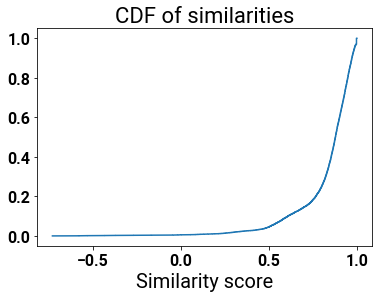

In [15]:
# Order similarity matrix rows by optimal cluster order
order_inds, cluster_ids = cluster_matrix_indices(
    cond_sim_matrix,
    max([len(inds) for inds in cond_inds.values()])
    # Maximum number of clusters should be biggest condition size
)
cond_sim_matrix = cond_sim_matrix[order_inds]

# Order motif keys and motifs
sorted_motif_keys = [motif_keys[i] for i in order_inds]
sorted_motifs = [motifs[i] for i in order_inds]
sorted_motif_prop_seqlets = np.array([motif_prop_seqlets[i] for i in order_inds])

# Sort each matrix row independently, most to least similar
cond_sim_matrix = -np.sort(-cond_sim_matrix, axis=1)  # Negatives make it sort descending

fig, ax = plt.subplots()
make_cdf(ax, np.ravel(cond_sim_matrix), density=True)
ax.set_title("CDF of similarities")
ax.set_xlabel("Similarity score")
plt.show()

# Normalize the matrix entries to percentile
cond_sim_matrix_perc = scipy.stats.rankdata(cond_sim_matrix).reshape(cond_sim_matrix.shape) / cond_sim_matrix.size

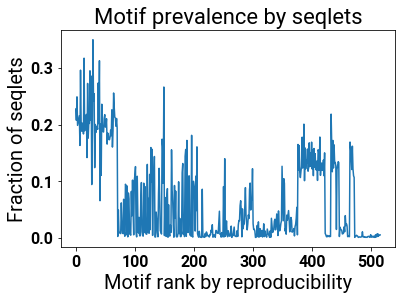

In [16]:
fig, ax = plt.subplots()
ax.set_title("Motif prevalence by seqlets")
ax.set_xlabel("Motif rank by reproducibility")
ax.set_ylabel("Fraction of seqlets")
ax.plot(sorted_motif_prop_seqlets)
plt.show()

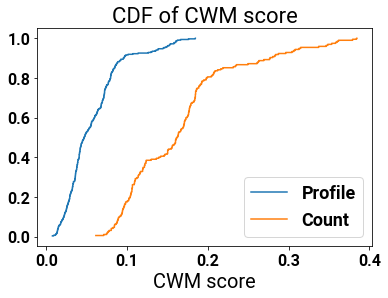

In [17]:
# Extract the CWM score of each motif in order
sorted_motif_scores = np.array([np.max(cwm) for cwm in sorted_motifs])

# Separate out profile and count CWMs
profile_inds = np.array([i for i in range(len(sorted_motif_keys)) if sorted_motif_keys[i].split(":")[-2] == "P"])
count_inds = np.array([i for i in range(len(sorted_motif_keys)) if sorted_motif_keys[i].split(":")[-2] == "C"])

fig, ax = plt.subplots()
make_cdf(ax, sorted_motif_scores[profile_inds], density=True, label="Profile")
make_cdf(ax, sorted_motif_scores[count_inds], density=True, label="Count")
ax.set_title("CDF of CWM score")
ax.set_xlabel("CWM score")
plt.legend()
plt.show()

# Normalize the CWM scores to map to percentile (i.e. map CDF x-axis to y-axis)
# Do counts/profile CWMs separately
sorted_motif_score_percs = np.empty_like(sorted_motif_scores)
sorted_motif_score_percs[profile_inds] = scipy.stats.rankdata(sorted_motif_scores[profile_inds]) / len(profile_inds)
sorted_motif_score_percs[count_inds] = scipy.stats.rankdata(sorted_motif_scores[count_inds]) / len(count_inds)

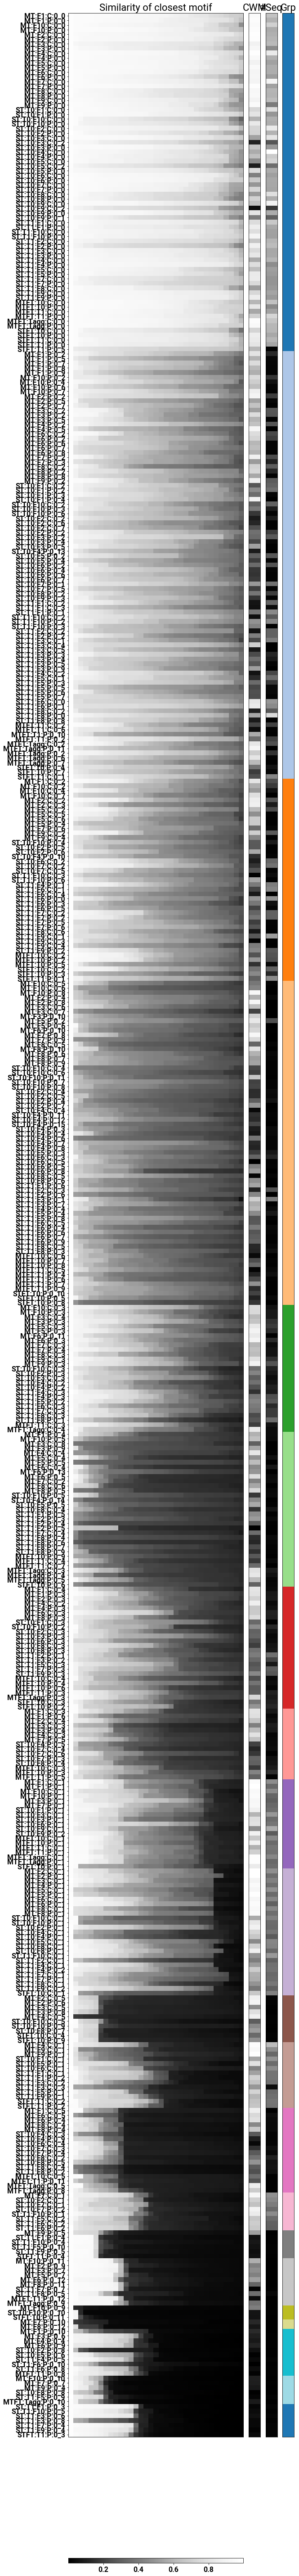

In [18]:
height = max(5, len(motif_keys) * 0.2) + 1
width = max(5, len(cond_inds) * 0.1) + 4

fig, ax = plt.subplots(
    nrows=2, ncols=4, figsize=(width, height),
    gridspec_kw={
        "width_ratios": [(width - 6) / 0.1, 2, 2, 2],
        "height_ratios": [height / 0.2, 1],
        "wspace": 0.1,
        "hspace": 0.1
    }
)

hmap = ax[0, 0].imshow(cond_sim_matrix_perc, cmap="Greys_r", aspect="auto")  # auto aspect to stretch
ax[0, 1].imshow(sorted_motif_score_percs[:, None], cmap="Greys_r", aspect="auto")
ax[0, 2].imshow(sorted_motif_prop_seqlets[:, None], cmap="Greys_r", aspect="auto")

# Cluster IDs may not be in order, so sort the groups
diffs = np.concatenate([[0], np.diff(cluster_ids)])
diffs[diffs != 0] = 1
reordered_cluster_ids = np.cumsum(diffs)
ax[0, 3].imshow(reordered_cluster_ids[:, None] % 20 / 20, cmap="tab20", aspect="auto")

ax[0, 0].set_yticks(np.arange(len(motif_keys)))
ax[0, 0].set_yticklabels(sorted_motif_keys)
ax[0, 0].set_xticks([])
ax[0, 0].set_title("Similarity of closest motif")
ax[0, 1].set_title("CWM")
ax[0, 2].set_title("#Seq")
ax[0, 3].set_title("Grp")

for i in range(1, 4):
    ax[0, i].set_yticks([])
    ax[0, i].set_xticks([])
    ax[1, i].axis("off")

fig.colorbar(hmap, cax=ax[1, 0], orientation="horizontal")

plt.show()

In [19]:
# Show some examples of motifs of high, medium, and low reproducibility
avg_sim = np.mean(cond_sim_matrix, axis=1)

slice_names = ["Most reproducible", "Semi reproducible", "Least reproducible"]
mid_avg = np.quantile(avg_sim, 0.5)
mid_ind = len(avg_sim) - np.searchsorted(-avg_sim, -mid_avg)
slice_inds = [
    np.arange(10),
    np.arange(mid_ind, mid_ind + 10),
    np.arange(len(avg_sim) - 10, len(avg_sim))
]
plot_motif_examples(sorted_motif_keys, sorted_motifs, slice_names, slice_inds)

/users/amtseng/tfmodisco/src/plot/viz_sequence.py:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<table><colgroup><col style="width: 3.3333333333333335%"></col><col style="width: 30.0%"></col><col style="width: 3.3333333333333335%"></col><col style="width: 30.0%"></col><col style="width: 3.3333333333333335%"></col><col style="width: 30.0%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif (Most reproducible)</th><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif (Semi reproducible)</th><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif (Least reproducible)</th></tr></thead><tbody><tr><td>MT:F1:C:0_0</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAACjX0lEQVR4nOzdd5xcVf3/8dedPjtb0gspJAFCL0LoIIgCooKCqIAFsaKiolj42uHrF8WviuXnV8WuiIUiAoL0jgESegIJIaSX3Wy2T585vz/O3J3ZzW52p%2B1seT8fj/uYsnPvnJm9M3Pv53zO5zjGGEREREREREREREREKs1T6waIiIiIiIiIiIiIyPikALSIiIiIiIiIiIiIVIUC0CIiIiIiIiIiIiJSFQpAi4iIiIiIiIiIiEhVKAAtIiIiIiIiIiIiIlWhALSIiIiIiIiIiIiIVIUC0CIiIiIiIiIiIiJSFQpAi4iIiIiIiIiIiEhVKAAtIiIiIiIiIiIiIlWhALSIiIiIiIiIiIiIVIWv1g0YjmnTppkFCxbUuhkiIiIiIiIiIiIiE97y5ct3GGOmD%2BexYyIAvWDBApYtW1brZoiIiIiIiIiIiIhMeI7jrB/uY0suweE4zscdx1nlOE7CcZz1juN8w3GcYW3PcZxzHccxueWYUtsgIiIiIiIiIiIiIqNXSRnQjuN8FPhF7mYUmA9cAdQBlw%2BxbhPwk1KeV0RERERERERERETGjlIzoL%2BWu/ySMSYCXJi7/VnHcRqHWPc7wOwSn1dERERERERERERExoiiA9CO4yzEZjwD/Cp3eR3QBYSAJbtZ91jgYuCBYp9XRERERERERERERMaWUjKg3ezllDGmHcAYkwWac/fPGmglx3H8wLVAEhuEFhEREREREREREZFxrJQAdCB3me13f7rf3/u7DDgI%2BB9jzOoSnldERERERERERERExpBSa0AXxXGcRcA3gJXA1cNc52OO4yxzHGdZS0tLVdsnIiIiIiIiIiIiIpVXSgA6lbv09rvfvZ0YYJ2rgDCwJ7DBcZxtBX/7l%2BM4V/ZfwRhzrTFmiTFmyfTp00topoiIiIiIiIiIiIjUkq%2BEddzgsc9xnBnGmGbHcTzAjNz9WwZYpy53GckthaYAjSW0Q0RERERERERERERGsVIyoNeSDzK7kwm%2BBxtEjgLL%2Bq9gjDnLGOMULgV/PtYYc2kJ7RARERERERERERGRUazoALQxxmBLagBc4ThOFLg%2Bd/tHxpgex3GudhznVcdx3lWphoqIiIiIiIiIiIjI2FJKCQ6MMT9zHAfgUnJ1nYHfAN/OPWQmMBtoKr%2BJIiIiIiIiIiIiIjIWlRSABhuEBn42yN8%2BCHxwiPWd3f1dRERERERERERERMa2UmpAi4iIiIiIiIiIiIgMSQFoEREREREREREREakKBaBFREREREREREREpCoUgBYRERERERERERGRqlAAWkRERERERERERESqQgFoEREREREREREREakKBaBFREREREREREREpCoUgBYRERERERERERGRqlAAWkRERERERERERESqQgFoEREREREREREREakKBaBFREREREREREREpCoUgBYRERERERERERGRqlAAWkRERERERERERESqQgFoEREREREREREREakKBaBFREREREREREREpCoUgBYRERERERERERGRqlAAWkRERERERERERESqQgFoEREREREREREREakKX60bICIiIiIyEoyBLVvgxRdh9Wro6YFEwv4tGIRIBBYvhoMOgj32AMepbXtFRERERMYDBaBFREREZFxKp%2BGhh%2BAvf4GlS2HtWnt/IGADz6kUZDL2Pq8X/H77t1TK3rdoERx9NJx/Ppx8Mvh05CwiIiIiUjQdRouIiIjIuJHNwmOPwe9/DzfeaLOeu7vtpSsW23W9TMYu8Xj%2BvhUrYOVKuOEGe/td74ILL4QTTgCPCtmJiIiIiAyLDp1FREREZMzLZOCPf7SlM976VhuA7uyErq6%2BwediGWO30dVlt/m2t9nn%2BMMf8tnTIiIiIiIyOAWgRURERGTMymZthvLChfCpT8H27TZYnM1W57m6uuxzXHKJfc4bbqjOc4mIiIiIjBcKQIuIiIjImPTII7DffvChD8HGjbbUxkjp7rbP%2BaEPwb77wsMPj9xzi4iIiIiMJQpAi4iIiMiYkkzCZZfB6afDK6%2BMbOC5v%2B5uWLMG3vxm26ZksnZtEREREREZjRSAFhEREZEx4%2BWX4dBD4Re/GHgywVqJxWybDjnEtlFERERERCwFoEVERERkTPjFL%2BDww2H1aohGa92aXUWjNiP78MPh5z%2BvdWtEREREREYHBaBFREREZFTLZuHTn7YlLmKx0T3pXzZr2/iFL9g2j%2Ba2ioiIiIiMBAWgRURERGTUSqXgPe%2BB3/52dGY9DyYahd/9zrY9lap1a0REREREakcBaBEREREZlXp64NRT4Y47xlbw2dXTY9t%2B6qn2uoiIiIjIRKQAtIiIiIiMOm1tcOyx8MQTYzP47IpG7Ws49lj7mkREREREJhoFoEVERERkVEkkbNbwqlUQj9e6NeWLx%2B1rOfXUWrdERERERGTkKQAtIiIiIqNGNgvvfjesXAnJZK1bUznJpH1NIiIiIiITjQLQIiIiIjJqfP7zcO%2B9EIvVuiWVNx5fk4iIiIjIUBSAFhEREZFR4Sc/gV/9amzXfBYRERERkb58tW6AiIiIiMi//w2XX64sYRERERGR8abkDGjHcT7uOM4qx3ESjuOsdxznG47jDLo9x3H2dRznRsdxdjqO0%2BE4zpOO45xX6vOLiIiIyPiwfTucd56CzyIiIiIi41FJGdCO43wU%2BEXuZhSYD1wB1AGXD/D4ecDjwBQgAySAI4G/OI4z3Rjz01LaISIiIiJjWzYL73qXym6IiIiIiIxXpWZAfy13%2BSVjTAS4MHf7s47jNA7w%2BA9hg89rgDlAA/DL3N8%2BXWIbRERERGSM%2B9GP4OmnIZWqdUtERERERKQaig5AO46zEJvxDPCr3OV1QBcQApYMsNofgWOBNxtjthtjssBtub9NK7YNIiIiIjL2Pf88fO1r0NNT65aIiIiIiEi1lFKCY3buMmWMaQcwxmQdx2nGZjbP6r%2BCMeY14DX3tuM404CP5G7eX0IbREREZJzo7oY1a2D1ali1yl6PxSAeB58PQiGYNg0OOAAWL4Z99oE5c8BT8kwWMhrE4/D2t9tLERERER